# Appendix：分位点回帰 (Quantile regression)

## 分位点回帰 (Quantile Regression)とは
通常の最小二乗法による線形回帰(Ordinary least squares regression)は，誤差が正規分布と仮定したとき(必ずしも正規分布を仮定しなくてもよい)の$X$(説明変数)に対する$Y$(目的変数)の期待値$E[Y]$を求める．これに対して**分位点回帰(quantile regression)** では，Xに対するYの分布における分位点を通るような直線を引く．

**分位点**(または分位数)において，代表的なものが**四分位数**である．四分位数は箱ひげ図などで用いるが，例えば第一四分位数は分布を25:75に分ける数，第二四分位数(中央値)は分布を50:50に分ける数である．同様に$q$分位数($q$-quantile)というと分布を$q:1-q$に分ける数となっている．分位点回帰の話に戻る．下図は$x\sim U(0, 5),\quad y=3x+x\cdot \xi,\quad \xi\sim N(0,1)$とした500個の点に対する分位点回帰である．青い領域はX=1,2,3,4でのYの分布を示している．紫，緑，黄色の直線はそれぞれ10, 50, 90%tile回帰の結果である．例えば50%tile回帰の結果は，Xが与えられたときのYの中央値(50%tile点)を通るような直線となっている．同様に90%tile回帰の結果は90%tile点を通るような直線となっている．

In [1]:
using PyPlot, LinearAlgebra, Random

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1317


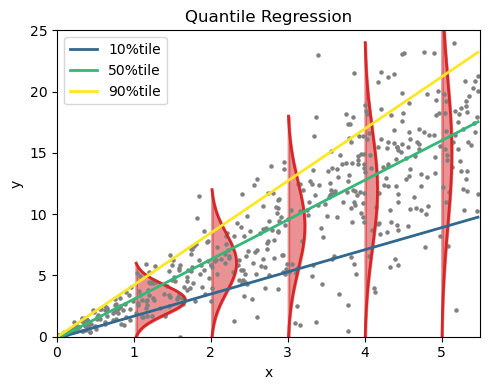

In [2]:
function QuantileGradientDescent(X, y, initθ, τ; lr=1e-4, num_iters=10000)
    θ = initθ
    for i in 1:num_iters
        ŷ = X * θ # predictions
        δ = y - ŷ  # error
        grad = abs.(τ .- 1.0(δ .<= 0.)) .* sign.(δ) # gradient
        θ += lr * X' * grad # Update
    end
    return θ
end;

function gaussian_func(x, μ, σ)
    return 0.8/σ*exp(-(x -μ)^2/(2σ^2))
end;

# Generate Toy datas
N = 500 # sample size
x = sort(5.5rand(N))
y = 3x + x .* randn(N);
X = ones(N, 2) # design matrix
X[:, 2] = x;
τs = [0.1, 0.5, 0.9]
m = length(τs) 
Ŷ = zeros(m, N); # memory array
for i in 1:m
    initθ = zeros(2) # init variables
    θ = QuantileGradientDescent(X, y, initθ, τs[i])
    Ŷ[i, :] = X * θ
end

# Results plot
figure(figsize=(5,4))
title("Quantile Regression")
for loc in 1:5
    ξy = 0:1e-3:6loc
    ξx = loc .+ gaussian_func.(ξy, 3loc, 1.2loc)
    fill_between(ξx, -1, ξy, color="tab:red", linewidth=2, alpha=0.5)
    plot(ξx, ξy, color="tab:red", linewidth=2)
end
cmvir = get_cmap(:viridis)
for i in 1:m
    plot(x, Ŷ[i, :], linewidth=2, label=string(Int(τs[i]*100))*"%tile", color=cmvir(i/m)) # regression line
end
scatter(x, y, color="gray", s=5) # samples
xlabel("x"); ylabel("y")
xlim(0, 5.5); ylim(0, 25); legend()
tight_layout()

分位点回帰の利点としては，外れ値に対して堅牢(ロバスト)である，Yの分布が非対称である場合にも適応できる，などがある ([Das et al., *Nat Methods*. 2019](https://www.nature.com/articles/s41592-019-0406-y))．


## 勾配法による線形回帰 (最小二乗法)

最小二乗法による線形回帰と異なり，分位点回帰は解析的に求めることができない．そのため，数値的に勾配法で求めるが，一先ずは最小二乗法による回帰直線を勾配法で求めてみよう．

簡単のために単回帰の場合を考える．パラメータを$\theta \in \mathbb{R}^2$, サンプルサイズを$n$, 説明変数の計画行列を$n \times 2$の行列$X$, 目的変数を$y \in \mathbb{R}^n$とする．ただし$X$と$y$は観測値である．$y$の予測値は$X \theta$なので，誤差 $\delta \in \mathbb{R}^n$は
$$\delta = y-X \theta$$ と表せる．最小二乗法において最適化したい目的関数は$$L(\delta)=\sum_{i=1}^n \delta_i^2 = \|\delta\|^2=\delta^T \delta$$ であり，$$\frac{\partial L}{\partial \theta}=-\frac{1}{n} \delta X$$
と表せるので，$\theta$の更新式は$\theta \leftarrow \theta + \alpha\cdot \dfrac{1}{n} \delta X$と書ける．ただし，$\alpha$は学習率である．

さて，これを実装したコードと結果は次のようになる．

In [3]:
# Ordinary least squares regression
function OLSRegGradientDescent(X, y, initθ; lr=1e-4, num_iters=10000)
    θ = initθ
    for i in 1:num_iters
        ŷ = X * θ # predictions
        δ = y - ŷ  # error
        θ += lr * X' * δ # Update
    end
    return θ
end;

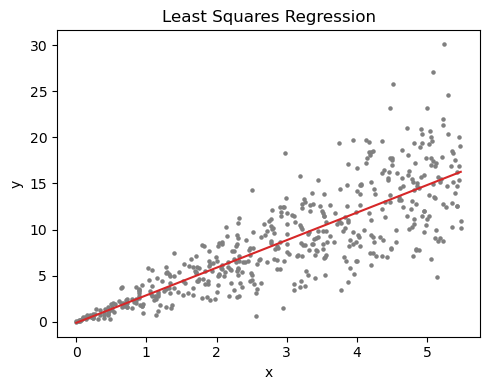

In [4]:
# Generate Toy datas
N = 500 # sample size
x = sort(5.5rand(N))
y = 3x + x .* randn(N);
X = ones(N, 2) # design matrix
X[:, 2] = x;
 
# Gradient descent
initθ = zeros(2) # init variables
θ = OLSRegGradientDescent(X, y, initθ)
ŷ = X * θ # predictions
 
# Results plot
figure(figsize=(5,4))
title("Least Squares Regression")
scatter(x, y, color="gray", s=5) # samples
plot(x, ŷ, color="tab:red")  # regression line
xlabel("x"); ylabel("y")
tight_layout()

上図において赤色の線が回帰直線である．今回は誤差を正規分布としているので綺麗な結果だが，実際には外れ値の影響を受けたりする．

## 勾配法による分位点回帰

本題の分位点回帰である．前節と同様の設定とする．ここで $\delta$の関数を $$\rho_{\tau}(\delta)=\left|\tau-\mathbb{I}_{\delta \leq 0}\right|\cdot |\delta|=\left(\tau-\mathbb{I}_{\delta \leq 0}\right)\cdot \delta$$
とします．ただし，$\tau$は関心のある分位点(quantile)，$\mathbb{I}$は指示関数(indicator function)です．この場合，$\mathbb{I}_{\delta \leq 0}$は$\delta \gt 0$なら0, $\delta \leq 0$なら1となります．このとき，分位点回帰の目的関数は $$L_{\tau}(\delta)
=\sum_{i=1}^n \rho_{\tau}(\delta_i)$$ です．なぜこの目的関数の最適化が$\tau$-分位点の回帰となるかについては[Quantile regressionのWikipedia](https://en.wikipedia.org/wiki/Quantile_regression)に詳細に書いてあります．また，$\rho_{\tau}(\delta)$を色々な $\tau$についてplotすると次図のようになります．


$\rho_{\tau}(\delta)$はリスク関数と呼ばれる？ check functionっぽい

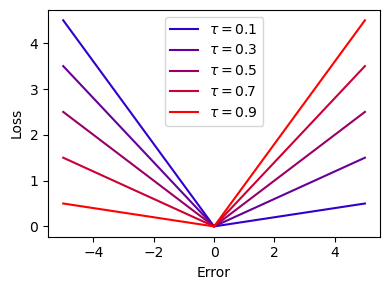

In [12]:
δ = -5:0.1:5
τ= 0.1:0.2:0.9
cmbrg = get_cmap(:brg) 
figure(figsize=(4,3))
for i in 1:length(τ)
    indic = 1.0(δ .<= 0)
    z = (τ[i] .- indic) .* δ
    plot(δ, z, color=cmbrg(0.5i/length(τ)), label=L"$\tau=$"*string(τ[i]))
end
xlabel("Error"); ylabel("Loss")
legend(); tight_layout()

それでは$L_\tau$を最小化するような$\theta$の更新式について考えていきましょう．まず，$$\frac{\partial \rho_{\tau}(\delta)}{\partial \delta}=\rho_{\tau}^{\prime}(\delta)=\left|\tau-\mathbb{I}_{\delta \leq 0}\right| \cdot
\operatorname{sign}(\delta)$$ です (ただしsignは符号関数)．さらに$$\frac{\partial L_{\tau}}{\partial \theta}=\frac{\partial L_{\tau}}{\partial \delta}\frac{\partial \delta(\theta)}{\partial \theta}=-\frac{1}{n}
\rho_{\tau}^{\prime}(\delta) X$$ が成り立つので，$\theta$の更新式は$\theta \leftarrow \theta + \alpha\cdot \dfrac{1}{n} \rho_{\tau}^{\prime}(\delta) X$と書けます ($\alpha$は学習率です)．ゆえに実装には前節のコードを少し修正すればよいです．

In [7]:
function QuantileGradientDescent(X, y, initθ, τ; lr=1e-4, num_iters=10000)
    θ = initθ
    for i in 1:num_iters
        ŷ = X * θ # predictions
        δ = y - ŷ  # error
        grad = abs.(τ .- 1.0(δ .<= 0.)) .* sign.(δ) # gradient
        θ += lr * X' * grad # Update
    end
    return θ
end;

In [8]:
# Generate Toy datas
τs = [0.01, 0.1, 0.5, 0.9, 0.99]
m = length(τs) 
Ŷ = zeros(m, N); # memory array
for i in 1:m
    initθ = zeros(2) # init variables
    θ = QuantileGradientDescent(X, y, initθ, τs[i])
    Ŷ[i, :] = X * θ
end

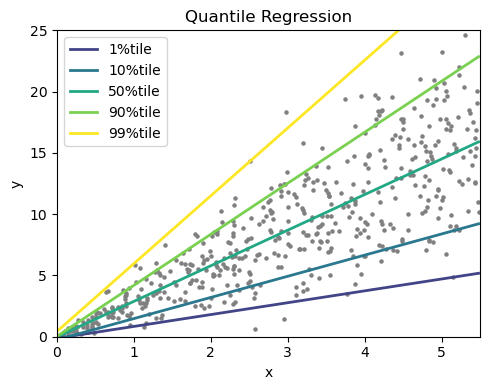

In [9]:
# Results plot
figure(figsize=(5,4))
title("Quantile Regression")
cm = get_cmap(:viridis)
for i in 1:m
    plot(x, Ŷ[i, :], linewidth=2, label=string(Int(τs[i]*100))*"%tile", color=cm(i/m)) # regression line
end
scatter(x, y, color="gray", s=5) # samples
xlabel("x"); ylabel("y")
xlim(0, 5.5); ylim(0, 25); legend()
tight_layout()

ただし，分位点回帰を単純な勾配法で求める場合，勾配が0となって解が求まらない可能性があるので避けた方が良いという話はある．そのために，目的関数を滑らかにするという研究もあります ([Zheng. *IJMLC*. 2011](https://link.springer.com/article/10.1007/s13042-011-0031-2))．

## Expectile回帰

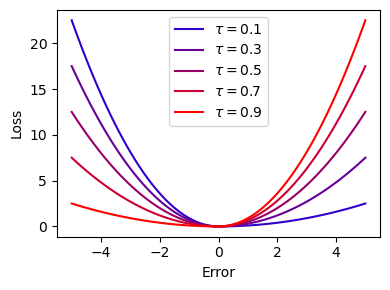

In [13]:
δ = -5:0.1:5
τ= 0.1:0.2:0.9
cmbrg = get_cmap(:brg) 
figure(figsize=(4,3))
for i in 1:length(τ)
    indic = 1.0(δ .<= 0)
    z = abs.(τ[i] .- indic) .* δ.^2
    plot(δ, z, color=cmbrg(0.5i/length(τ)), label=L"$\tau=$"*string(τ[i]))
end
xlabel("Error"); ylabel("Loss")
legend(); tight_layout()

In [15]:
function ExpectileGradientDescent(X, y, initθ, τ; lr=1e-4, num_iters=10000)
    θ = initθ
    for i in 1:num_iters
        ŷ = X * θ # predictions
        δ = y - ŷ  # error
        grad = 2*abs.(τ .- 1.0(δ .<= 0.)) .* δ # gradient
        θ += lr * X' * grad # Update
    end
    return θ
end;

In [16]:
# Generate Toy datas
τs = [0.01, 0.1, 0.5, 0.9, 0.99]
m = length(τs) 
Ŷ = zeros(m, N); # memory array
for i in 1:m
    initθ = zeros(2) # init variables
    θ = ExpectileGradientDescent(X, y, initθ, τs[i])
    Ŷ[i, :] = X * θ
end

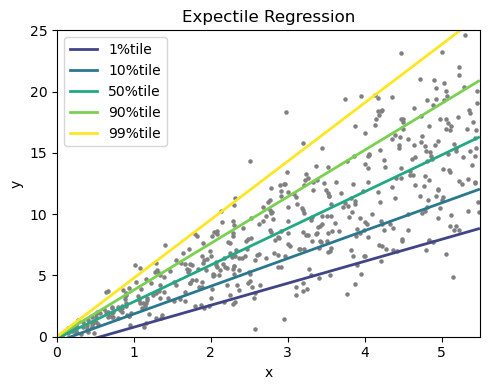

In [17]:
# Results plot
figure(figsize=(5,4))
title("Expectile Regression")
cm = get_cmap(:viridis)
for i in 1:m
    plot(x, Ŷ[i, :], linewidth=2, label=string(Int(τs[i]*100))*"%tile", color=cm(i/m)) # regression line
end
scatter(x, y, color="gray", s=5) # samples
xlabel("x"); ylabel("y")
xlim(0, 5.5); ylim(0, 25); legend()
tight_layout()

## 参考文献
- https://en.wikipedia.org/wiki/Quantile_regression
- Das, K., Krzywinski, M. & Altman, N. Quantile regression. Nat Methods 16, 451–452 (2019) doi:[10.1038/s41592-019-0406-y](https://www.nature.com/articles/s41592-019-0406-y)
- Quantile and Expectile Regressions ([pdf](https://freakonometrics.hypotheses.org/files/2017/05/erasmus-1.pdf))